In [4]:
from pandas import Series
import pandas as pd
import numpy as np

#библиотеки для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

#библиотеки для оценки значимости факторов в моделях и для предобработки данных
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

#библиотеки для разбиения датасета, тренировок моделей и поиска оптимального гиперпараметра
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#оценки качества классификации
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, precision_score, recall_score

#библиотеки отбора признаков и оценки их значимости
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2

In [5]:
#функция вывода оценок качества классификации
def print_regression_metrics(y_valid, y_pred, y_proba):
    f1 = f1_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_proba)
    cm = confusion_matrix(y_valid, y_pred)
    print(f'f1 = {f1:.3f}, recall = {recall:.3f}, precision = {precision:.3f}, auc = {auc:.3f}')
    print('confusion_matrix:', cm, sep='\n')
    
#функция тренировки модели и вывода оценок качества модели с графиком ROC-AUC
def train_validate(X, y,):
    # Разбить данные на train/valid
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # Создать и обучить логистическую регрессию
    C = np.logspace(0, 4, 10) #задаем ряд гиперпараметра L2 регуляризации
    hyperparameters = dict(C=C)
    logreg = LogisticRegression(max_iter=1000, class_weight = 'balanced') #введем требование балансировки данных, регуляризация по дефолту L2
    logreg.fit(X_train, y_train)
    clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
    logreg_best = clf.fit(X_train, y_train)
    print('Лучшее C:', round(logreg_best.best_estimator_.get_params()['C'],4))

    # Сделать предсказания по валидционной выборке
    y_pred = logreg_best.predict(X_valid)
    y_proba = logreg_best.predict_proba(X_valid)[:,1]
#    y_proba_test = logreg_best.predict_proba(X_test)[:,0]
#    y_proba_test_df = pd.DataFrame(data=y_proba_test, columns=['default'])
#    y_proba_test_df.to_csv('C:/Users/Алексей Третьяков/Desktop/Pyth/Машинное обучение/submission_prob.csv')
    
    
    # Посчитать значение метрик качества классификации для валидационных данных
    print_regression_metrics(y_valid, y_pred, y_proba)
    
    # рассчитываем roc-кривую
    fpr, tpr, treshold = roc_curve(y_valid, y_proba)
    roc_auc = auc(fpr, tpr)
    # строим график
    plt.plot(fpr, tpr, color='darkorange',
    label='ROC кривая (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.show()
    print('Средняя вероятность:', round(np.mean(y_proba),4))

In [6]:
#загружаем данные в датафрейм и смотрим агрегированную инфо по ним
train = pd.read_csv('C:/Users/Алексей Третьяков/Desktop/Pyth/Машинное обучение/train.csv')
test = pd.read_csv('C:/Users/Алексей Третьяков/Desktop/Pyth/Машинное обучение/test.csv')
sample_submission = pd.read_csv('C:/Users/Алексей Третьяков/Desktop/Pyth/Машинное обучение/sample_submission.csv')

train['id'] = 0
test[['id','default']] = 1

data = pd.concat([train,test])
data.info()
#есть пропущенные значения (307 значений) в категориальном признаке education

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

In [7]:
#как оказалось даты несут информацию) хотя и не скажешь) не будем выбрасывать их и выделим месяц из дат (год один 2014) и сделаем категориальный признак
data['month'] = data['app_date'].apply(lambda x: x[2:5])
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,id,month
32537,62812,12MAR2014,UGR,M,25,Y,N,0,0,-2.410540,...,40,1,3,40000,1,4,N,0,0,MAR
32743,99263,16APR2014,GRD,M,28,N,N,0,0,-2.136645,...,60,2,3,45000,4,2,N,0,0,APR
6571,43974,20FEB2014,SCH,M,25,N,N,0,0,-1.920823,...,40,2,3,15000,4,2,N,1,1,FEB
9174,100307,17APR2014,SCH,F,44,Y,N,0,0,-2.453007,...,60,2,3,27000,2,4,N,0,0,APR
13571,1054,05JAN2014,UGR,F,45,N,N,1,0,-2.146134,...,50,1,2,19000,3,3,N,1,1,JAN


# Заполнение пропущенных данных в education

In [8]:
#Попробуем найти коррелияции признака education с другими признаками
#для этого используем тест Хи квадрат, так как признак категориальный и остальные признаки во многом бинарные или категориальные

#Для начала сделаем все категориальные и бинарные признаки с текстом числовыми категориями
labelencoder = LabelEncoder()
data['sex'] = labelencoder.fit_transform(data['sex'])
data['car'] = labelencoder.fit_transform(data['car'])
data['car_type'] = labelencoder.fit_transform(data['car_type'])
data['foreign_passport'] = labelencoder.fit_transform(data['foreign_passport'])
data['education'] = labelencoder.fit_transform(data['education'])
data['month'] = labelencoder.fit_transform(data['month'])

#текстовых значений не осталось, кроме даты подачи заявления. Пропущенные значения заменились на число 5.
data.sample(5)
data.education.value_counts()

3    57998
1    34768
4    14748
2     1865
5      478
0      291
Name: education, dtype: int64

In [9]:
#сделаем сет для Хи квадрат теста и сам тест
X_select = data[data.education != 5].drop(['education','default','app_date','client_id','score_bki','income','age'], axis=1).values
y_select = data[data.education != 5].education.values
chi2(X_select,y_select)[0]

#Выберем первые пять признаков с максимальным значением Хи квадрат: region_rating, car_type, foreign_passport, good_work, car
#car не будем использовать, так как коррелирует с car_type

#для прогнозирования пропусков (теперь они помечены цифрой 5) используем метод К-соседей по выбранным с тестом Хи квадрат 4-м признакам
#тренировочный сет для K-соседей, стандартизируем признаки
X_k_train = data[data.education != 5][['region_rating', 'car_type', 'foreign_passport', 'good_work']].values
X_k_train_scaled = StandardScaler().fit_transform(X_k_train)

y_select.shape, X_k_train_scaled.shape

((109670,), (109670, 4))

In [10]:
#сет для прогноза образования по модели K-neighbors
X_k_pred = data[data.education == 5][['region_rating', 'car_type', 'foreign_passport', 'good_work']].values
X_k_pred_scaled = StandardScaler().fit_transform(X_k_pred)
X_k_pred.shape

(478, 4)

In [11]:
#прогнозируем отсутствующие значения в education
clusterer = KNeighborsClassifier(11, weights='distance')
clusterer.fit(X_k_train_scaled,y_select)
y_k_pred = clusterer.predict(X_k_pred_scaled)

y_k_pred_df = pd.DataFrame(data=y_k_pred, columns=['ed'])
y_k_pred_df
y_k_pred_df.ed.value_counts()# прогноз получился только по категориям 3 и 1

3    275
1    203
Name: ed, dtype: int64

In [12]:
#вариант прогноза деревьями, но он не улчшил качество модели, поэтому не используем его
clusterer = RandomForestClassifier(n_estimators=100)
clusterer.fit(X_k_train,y_select)
y_k_pred_trees = np.round(clusterer.predict(X_k_pred))

y_k_pred_trees_df = pd.DataFrame(data=y_k_pred_trees, columns=['ed'])
y_k_pred_trees_df.ed.value_counts()

3    369
1    109
Name: ed, dtype: int64

In [13]:
#дозаполняем колонку прогнозными значениями
data_na = data[data.education == 5]
data_na.education = y_k_pred_trees_df['ed'].values

data = pd.concat([data_na,data[data.education != 5]])

data.info()
data.education.value_counts() #все, теперь полный датасет и осталась только одна текстовая колонка с датой подачи заявлений

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 517 to 36348
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  int32  
 3   sex               110148 non-null  int32  
 4   age               110148 non-null  int64  
 5   car               110148 non-null  int32  
 6   car_type          110148 non-null  int32  
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        1

c:\users\алексей третьяков\appdata\local\programs\python\python39\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


3    58367
1    34877
4    14748
2     1865
0      291
Name: education, dtype: int64

# Предобработка численных данных

<AxesSubplot:>

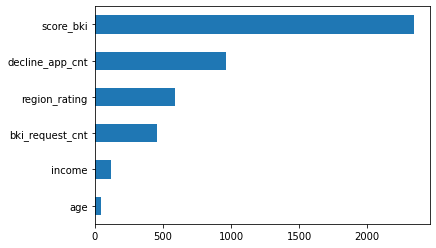

In [14]:
#Сделаем список численных колонок и посмотри их значимость для прогнозного признака
num_cols = ['age','decline_app_cnt','bki_request_cnt','income','score_bki','region_rating']
imp_num = pd.Series(f_classif(data[data.id == 0][num_cols], data[data.id == 0]['default'])[0], index=num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#признаки age и income не значимые и в будущем их можно попробовать удалить

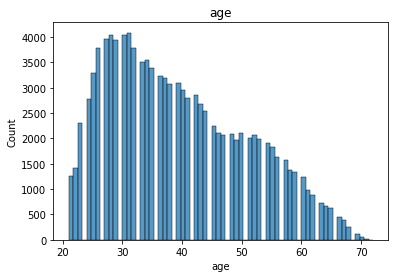

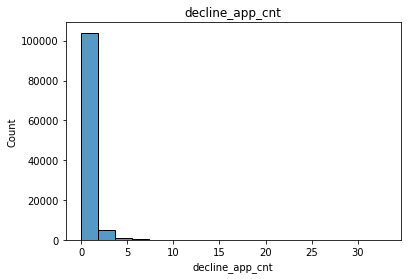

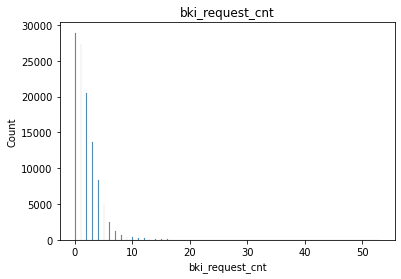

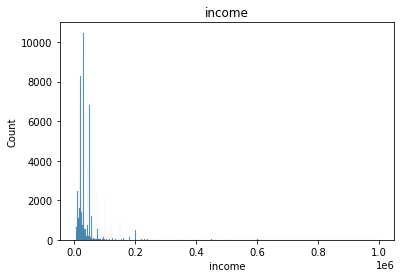

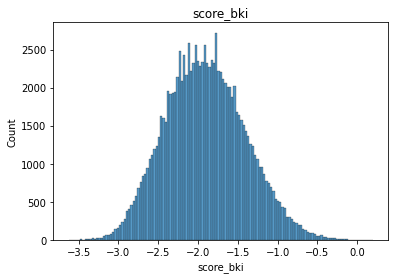

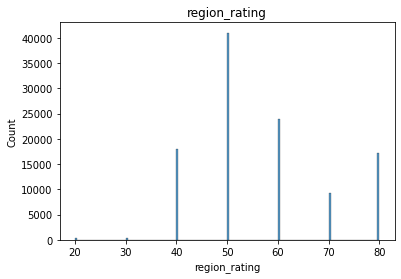

In [15]:
#посмотрим на распределение численных признаков
for i in num_cols:
    plt.figure()
    sns.histplot(data=data[i])
    plt.title(i)
    plt.show()

#часть признаков надо нормализовать

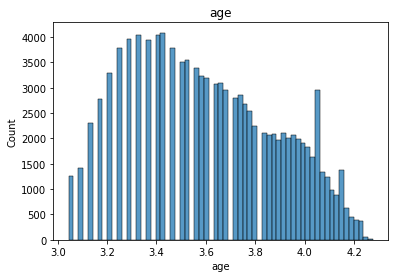

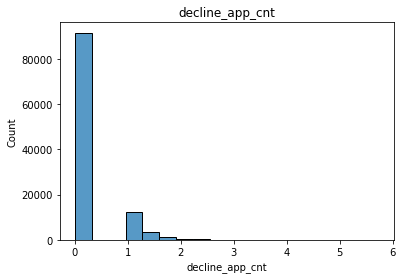

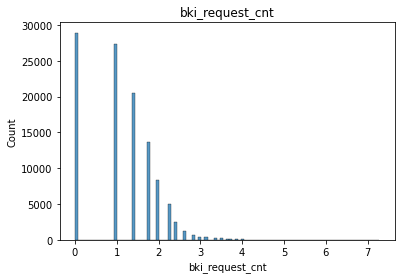

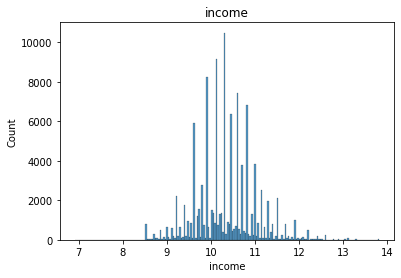

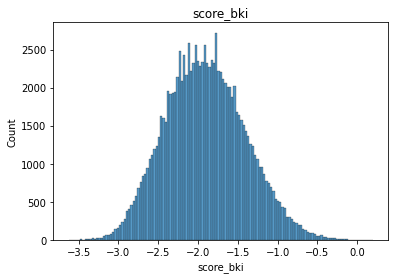

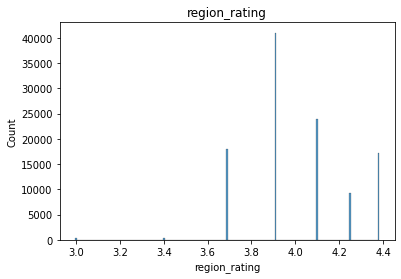

In [16]:
#нормализация признаков
data.income = data.income.apply(lambda x: np.log(x))
data.age = data.age.apply(lambda x: np.log(x))
data.bki_request_cnt = data.bki_request_cnt.apply(lambda x: np.sqrt(x))
data.decline_app_cnt = data.decline_app_cnt.apply(lambda x: np.sqrt(x))
data.region_rating = data.region_rating.apply(lambda x: np.log(x))

#посмотрим на новые распределения численных признаков
for i in num_cols:
    plt.figure()
    sns.histplot(data=data[i])
    plt.title(i)
    plt.show()

# Обработка коллинеарных признаков

<AxesSubplot:>

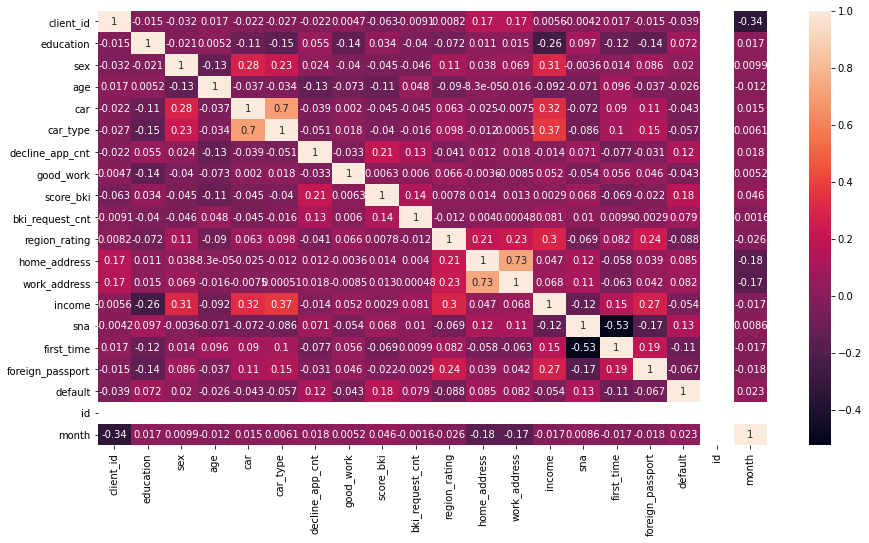

In [17]:
#посмотрим есть ли сильные корреляции между признаками
heatmap = plt.figure(figsize=(15, 8))
sns.heatmap(data[data.id == 0].corr(), annot=True)

<AxesSubplot:xlabel='car_new', ylabel='Count'>

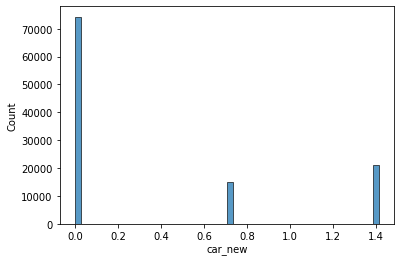

In [18]:
#car и car_type сильно коррелируют
#удалять один из них не будем, а сделаем из них один признак с помощью выделения главной компоненты
corr_matrix = data[['car','car_type']].corr()
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

index = np.argmax(eigenvalues)
eigenvectors.T[index]

a1 = eigenvectors.T[index][0]
a2 = eigenvectors.T[index][1]

data['car_new'] = a1*data['car']+a2*data['car_type'] #новый признак и он уже не бинарный
sns.histplot(data['car_new'])

<AxesSubplot:xlabel='address_new', ylabel='Count'>

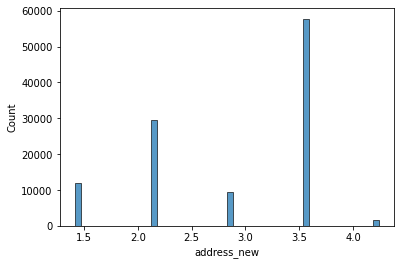

In [19]:
#home_address и work_address сильно коррелируют
#удалять один из них не будем, а сделаем из них один признак с помощью выделения главной компоненты
corr_matrix_add = data[['home_address','work_address']].corr()
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix_add)

index = np.argmax(eigenvalues)
eigenvectors.T[index]

a1 = eigenvectors.T[index][0]
a2 = eigenvectors.T[index][1]

data['address_new'] = a1*data['home_address']+a2*data['work_address'] #новый признак
sns.histplot(data['address_new'])

<AxesSubplot:xlabel='sna_new', ylabel='Count'>

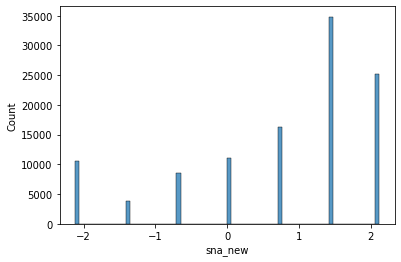

In [20]:
#first_time и sna коррелируют
#удалять один из них не будем, а сделаем из них один признак с помощью выделения главной компоненты
corr_matrix_fsna = data[['first_time','sna']].corr()
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix_fsna)

index = np.argmax(eigenvalues)
eigenvectors.T[index]

a1 = eigenvectors.T[index][0]
a2 = eigenvectors.T[index][1]

data['sna_new'] = a1*data['first_time']+a2*data['sna'] #новый признак
sns.histplot(data['sna_new'])

<AxesSubplot:>

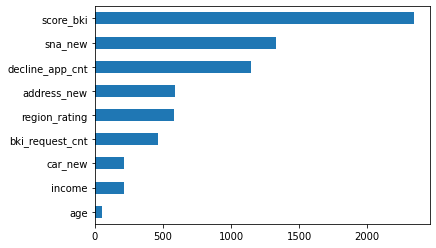

In [21]:
#будем считать новые колонки численными и добавим их в список численных колонок
num_cols.append('car_new')
num_cols.append('address_new')
num_cols.append('sna_new')
imp_num = pd.Series(f_classif(data[data.id == 0][num_cols], data[data.id == 0]['default'])[0], index=num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#попрежнему incom age можно поробовать удалить как незначимые признаки

<AxesSubplot:>

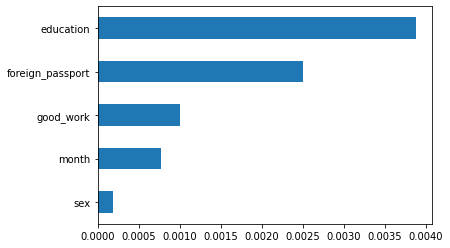

In [22]:
#сделаем еще списки категориальных и бинарных колонок и посмотрим их значимость
cat_cols = ['education','month']
bin_cols = ['sex','good_work','foreign_passport']
imp_cat_bin = Series(mutual_info_classif(data[data.id == 0][bin_cols + cat_cols], data[data.id == 0]['default'],
discrete_features =True), index = bin_cols + cat_cols)
imp_cat_bin.sort_values(inplace = True)
imp_cat_bin.plot(kind = 'barh')

#признак sex также можно попробовать удалить

In [23]:
#data_model = data.drop(['sex','age'], axis=1)
#bin_cols.remove('sex')
#num_cols.remove('age')

#сделаем отделение тестового блока данных
data_test = data[data.id == 1].drop(['id','default'],axis=1)
data_train = data[data.id == 0].drop('id',axis=1)

#сделаем undersampling
num_0 = len(data_train[data_train.default == 0])
num_1 = len(data_train[data_train.default == 1])

data_undersampled = pd.concat([data_train[data_train.default == 0].sample(num_1, random_state=30),data_train[data_train.default == 1]])

<AxesSubplot:>

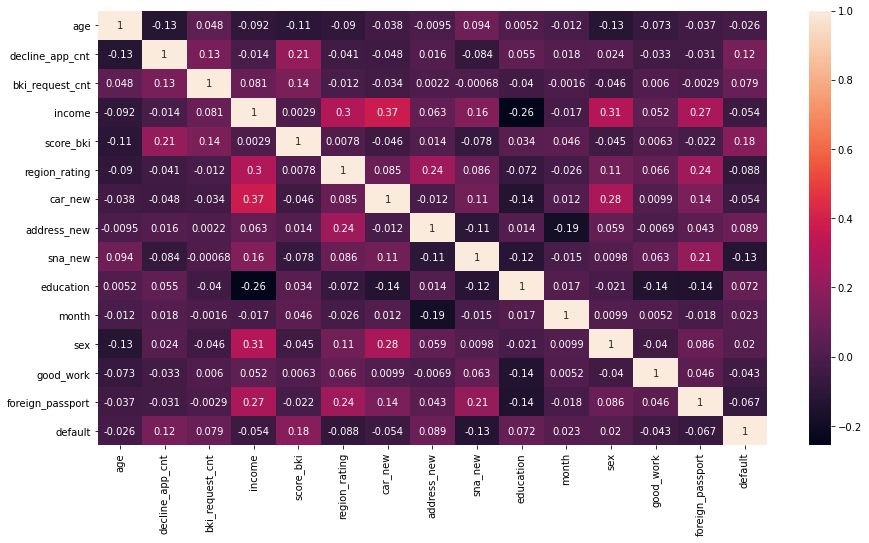

In [24]:
heatmap = plt.figure(figsize=(15, 8))
sns.heatmap(data_train[num_cols+cat_cols+bin_cols+['default']].corr(), annot=True)
#сильных корреляций вроде не осталось

# Моделирование

In [25]:
#подготовим данные для передачи модели
#переведем категориальные признаки в бинарные, а численные стандартизируем, потом соберем их вместе
X_cat = OneHotEncoder(sparse = False).fit_transform(data_undersampled[cat_cols].values)
X_num = StandardScaler().fit_transform(data_undersampled[num_cols].values)
pol_f = PolynomialFeatures (degree=2, include_bias=False) #добавим новых признаков второй степени из числовых признаков
X_num_pol = pol_f.fit_transform(X_num)

X = np.hstack([X_num_pol, data_undersampled[bin_cols].values, X_cat])
y = data_undersampled['default'].values

X_cat_test = OneHotEncoder(sparse = False).fit_transform(data_test[cat_cols].values)
X_num_test = StandardScaler().fit_transform(data_test[num_cols].values)
pol_f = PolynomialFeatures (degree=2, include_bias=False) #добавим новых признаков второй степени из числовых признаков
X_num_test_pol = pol_f.fit_transform(X_num_test)

X_test = np.hstack([X_num_test_pol, data_test[bin_cols].values, X_cat_test])

X.shape, y.shape, X_test.shape

((18744, 66), (18744,), (36349, 66))

Лучшее C: 166.8101
f1 = 0.681, recall = 0.700, precision = 0.662, auc = 0.738
confusion_matrix:
[[1221  666]
 [ 558 1304]]


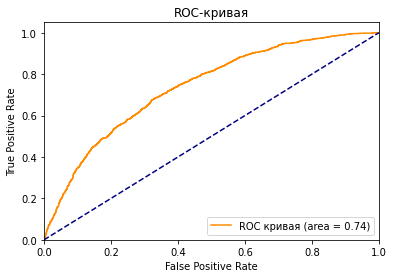

Средняя вероятность: 0.5005


In [26]:
#запускаем модель и смотрим качество модели
train_validate(X, y)

# Прогноз для тестовых данных to submit to Kaggle competition

In [27]:
#повторим моделирование для тестовых данных
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C)
logreg = LogisticRegression(max_iter=1000, class_weight = 'balanced') #введем требование балансировки данных, регуляризация по дефолту L2
logreg.fit(X, y)
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
logreg_best = clf.fit(X, y)
print('Лучшее C:', round(logreg_best.best_estimator_.get_params()['C'],4))

# Сделать предсказания вероятности дефолта
y_proba_test = logreg_best.predict_proba(X_test)[:,1]
y_proba_test_df = pd.DataFrame(data=y_proba_test, columns=['default'])

y_proba_test_df['client_id'] = data_test['client_id'].values
submission = y_proba_test_df.set_index('client_id')
submission.to_csv('C:/Users/Алексей Третьяков/Desktop/Pyth/Машинное обучение/submission.csv')

submission

Лучшее C: 21.5443


,default
client_id,
80556,0.750206
72640,0.380766
102865,0.135415
16559,0.557719
87995,0.797380
...,...
83775,0.807701
106254,0.106255
81852,0.762906
